# **Section 1 — Setup & Imports**

In [1]:
# %pip install -r requirements.txt
from math import cos, sin, pi
import numpy as np
import tqdm
import json
import google.generativeai as genai
import os
import pickle
import matplotlib.pyplot as plt
from collections import deque
import random
from typing_extensions import DefaultDict

# ============================================================
# API CONFIG
# ============================================================


API_KEY = ''
genai.configure(api_key=API_KEY)

# **Section 2 — Model & Dynamics**

In [2]:
x1_max = 10
x2_max = 10
u1_min = 0.25
u1_max = 1
u2_min = -1
u2_max = 1
w1_max = 0.05
w2_max = 0.05
w3_max = 0.05
tau = 1
Nx1 = 40
Nx2 = 40
Nx3 = 30
Nu1 = 3
Nu2 = 5
x1_min = 0
x2_min = 0
theta_min = -np.pi
theta_max = np.pi


def f(xt, ut, wt):
  raw_theta = xt[2] + tau * ut[1] + tau * wt[2]
  wrapped_theta = (raw_theta + np.pi) % (2 * np.pi) - np.pi

  return (xt[0] + tau * ut[0] * cos(xt[2]) + tau * wt[0],
          xt[1] + tau * ut[0] * sin(xt[2]) + tau * wt[1],
          wrapped_theta)

# **Section 3 — Regions & Labels**

In [3]:
regions = {}
danger_zones = {}
regions_number = 0
danger_zones_number = 0
All_regions = {}
region_for_labels = []
CORE_LABELS = ["none"]
labelTable = []

In [4]:
# ============================================================
# REGION VALIDATION
# ============================================================

def validate_region(rect):
    if not isinstance(rect, list) or len(rect) != 2:
        return False
    if not isinstance(rect[0], list) or not isinstance(rect[1], list):
        return False
    if len(rect[0]) != 2 or len(rect[1]) != 2:
        return False
    x1, x2 = rect[0]
    y1, y2 = rect[1]
    return x1 < x2 and y1 < y2


# ============================================================
# UNIFIED SINGLE-SHOT SUPERPROMPT (REGIONS + DFA)
# ============================================================
def build_unified_prompt(user_spec, regions_source, regions, danger_zones):
    import json

    # Everything that needs interpolation goes here
    header = f"""
You are the architect of a Symbolic Control Pipeline for a nonlinear mobile robot.
You operate strictly as a Formal Methods engine: deterministic, rule-driven, and
mathematically precise. You do NOT behave like a creative assistant.

====================================================================
USER SPECIFICATION
====================================================================
\"\"\"{user_spec}\"\"\"

====================================================================
REGION SOURCE AND USER REGIONS
====================================================================
regions_source = "{regions_source}"

If regions_source == "user", you MUST use the regions as provided:

safe_regions = {json.dumps(regions)}
danger_zones = {json.dumps(danger_zones)}

If regions_source == "ai", you MUST generate safe/danger regions yourself
according to the rules defined below.

"""

    # Everything that contains curly braces must be in a RAW string literal.
    core_prompt = r"""
====================================================================
SYSTEM CONSTRAINTS
====================================================================
1. Workspace:
   - Continuous domain: x ∈ [0, 10], y ∈ [0, 10].
   - θ is irrelevant for region geometry.
2. Abstraction:
   - You must describe the workspace as a finite set of labeled rectangular regions.
3. Implicit Label:
   - "none" represents free space (any coordinate not inside a region).
4. Symbolic Controller:
   - The controller operates on the product (SymbolicState × AutomatonState).

====================================================================
STEP 1 — REGION ENGINEERING
====================================================================
If regions_source == "user":
    - YOU MUST use the provided regions EXACTLY.
    - Do NOT rename, shrink, expand, subdivide, or merge them.
    - The alphabet becomes: ["none"] + safe_region_names + danger_zone_names.

If regions_source == "ai":
    You MUST generate safe/danger rectangular regions consistent with the user's task.

AI-GENERATED REGION RULES:
- Rectangles must be axis-aligned and inside [0,10]×[0,10].
- EXACT FORMAT: [[xmin, xmax], [ymin, ymax]]
- xmin < xmax and ymin < ymax.
- NO nested lists, no extra wrapping.
- Width ≥ 0.5 and Height ≥ 0.5 (unless user specification explicitly requires tiny shapes).
- NO overlapping safe regions.
- If the task implies a sequence (A→B→C), regions must be named:
      R_safe_1, R_safe_2, R_safe_3, ...
  in the correct order.
- If the task implies avoidance, generate:
      R_unsafe_1, R_unsafe_2, ...
  with the same rectangle format.
- After region creation:
      alphabet = ["none"] + all safe region names + all unsafe region names.

====================================================================
STEP 2 — DFA CONSTRUCTION RULES
====================================================================
Construct a fully explicit Deterministic Finite Automaton (DFA) enforcing the task.

The DFA MUST include:
- "states": list of strings.
- "initial": "q0".
- "accepting": list of accepting states.
- "transitions": full list of transitions.
- A trap state EXACTLY named "q_trap".

STRICT DFA REQUIREMENTS:

1. DETERMINISM:
   For every state S and every label σ in the alphabet,
   EXACTLY ONE transition δ(S,σ) MUST appear.

2. COMPLETENESS:
   - No missing transitions.
   - No ellipses "...".
   - No omitted cases.
   - No wildcards "*" or "otherwise".

3. FREE-SPACE RULE:
   In q0 and all intermediate states:
       δ(q, "none") = q
   unless the task explicitly contradicts this.

4. SEQUENCE LOGIC:
   For a sequence like "visit A then B then C":
     q0 --A--> q1 --B--> q2 --C--> q3
   - Premature region arrivals should self-loop unless strict ordering is implied.

5. AVOIDANCE LOGIC:
   For any avoidance region X:
       δ(q, X) = q_trap
   for all q except q_trap.

6. ACCEPTING STATE:
   q_accept MUST self-loop on ALL labels.

7. TRAP STATE:
   q_trap MUST self-loop on ALL labels.

8. STATE NAMING:
   Only use: "q0", "q1", "q2", ..., "q_accept", "q_trap".

====================================================================
STEP 3 — INTERNAL REASONING (DO NOT OUTPUT)
====================================================================
Before you generate the JSON:
- Infer the required regions.
- Build the alphabet.
- Determine state progression.
- Build the FULL transition table (states × alphabet).
- Ensure every rule above is followed exactly.

Do NOT output this reasoning. Only use it internally.

====================================================================
FINAL OUTPUT FORMAT (STRICT)
====================================================================
You MUST output exactly ONE JSON object:

{
  "regions": {
     "R_safe_1": [[xmin,xmax],[ymin,ymax]],
     ...
  },
  "danger_zones": {
     "R_unsafe_1": [[xmin,xmax],[ymin,ymax]],
     ...
  },
  "alphabet": ["none", ...],
  "automaton": {
      "states": [...],
      "initial": "q0",
      "accepting": [...],
      "transitions": [
         {"from": "...", "label": "...", "to": "..."},
         ...
      ]
  }
}

NO commentary.
NO markdown.
NO explanation.
JSON ONLY.
"""

    return header + core_prompt



In [5]:
# Core labels the automata understand


def sanitize_label(label):
    """
    Convert dynamic or unknown labels into a special 'FORBIDDEN' token.
    Anything in danger_zones or not in CORE_LABELS is treated as forbidden.
    """
    if label in danger_zones:
        return "FORBIDDEN"

    if label not in CORE_LABELS:
        return "FORBIDDEN"

    return label


def rectangles_collide(A, B):
    """AABB collision"""
    Ax1, Ay1, Ax2, Ay2 = A
    Bx1, By1, Bx2, By2 = B

    # Normalize (ensure x1 < x2 and y1 < y2)
    Ax1, Ax2 = min(Ax1, Ax2), max(Ax1, Ax2)
    Ay1, Ay2 = min(Ay1, Ay2), max(Ay1, Ay2)
    Bx1, Bx2 = min(Bx1, Bx2), max(Bx1, Bx2)
    By1, By2 = min(By1, By2), max(By1, By2)

    no_overlap = (
        Ax2 < Bx1 or  # A is left of B
        Bx2 < Ax1 or  # B is left of A
        Ay2 < By1 or  # A is above B
        By2 < Ay1     # B is above A
    )

    return not no_overlap


def labels(state):
    low, up = get_cell_bounds(state)
    cx = (low[0] + up[0]) / 2.0
    cy = (low[1] + up[1]) / 2.0

    for index, region in enumerate(region_for_labels):
        is_safe_region = index < regions_number
        r_xmin, r_ymin, r_xmax, r_ymax = region
        if is_safe_region:
            if r_xmin <= cx <= r_xmax and r_ymin <= cy <= r_ymax:
                return CORE_LABELS[index+1]
        else:
            if rectangles_collide((low[0], low[1], up[0], up[1]), region):
                return CORE_LABELS[index+1]
    return "none"

# **Section 4 — Discretization Utilities**

In [6]:
# Grid edges
x1_edges = np.linspace(x1_min, x1_max, Nx1 + 1)
x2_edges = np.linspace(x2_min, x2_max, Nx2 + 1)
theta_edges = np.linspace(theta_min, theta_max, Nx3 + 1)

In [7]:
def q(x):
    x1, x2, th = x
    # np.digitize returns 1-based bin index; subtract 1 for 0-based
    i = np.digitize(x1, x1_edges) - 1
    j = np.digitize(x2, x2_edges) - 1
    k = np.digitize(th, theta_edges) - 1

    return (int(i), int(j), int(k))

def q_inv(symbolic_state):
    """
    Inverse of q(x) - maps symbolic state to continuous coordinates
    Returns the CENTER of the cell
    """
    i, j, k = symbolic_state

    # Get the bounds of the cell
    x1_lo, x1_hi = x1_edges[i], x1_edges[i+1]
    x2_lo, x2_hi = x2_edges[j], x2_edges[j+1]
    th_lo, th_hi = theta_edges[k], theta_edges[k+1]

    # Return the center of the cell
    x1_center = (x1_lo + x1_hi) / 2.0
    x2_center = (x2_lo + x2_hi) / 2.0
    th_center = (th_lo + th_hi) / 2.0

    return (x1_center, x2_center, th_center)

def state_to_index(state):
    i, j, k = state
    return i * (Nx2 * Nx3) + j * Nx3 + k

def index_to_state(index):
    i = index // (Nx2 * Nx3)
    rem = index % (Nx2 * Nx3)
    j = rem // Nx3
    k = rem % Nx3
    return (i, j, k)

In [8]:
u1 = [0.25, 0.4, 0.6]
u2 = [-1, -0.5, 0, 0.5, 1]
u = [(u1[i], u2[j]) for i in range(Nu1) for j in range(Nu2)]

def p(sigma):
  return u[sigma]

In [9]:
def get_cell_bounds(symbolic_state):
    i, j, k = symbolic_state
    x1_lo, x1_hi = x1_edges[i], x1_edges[i+1]
    x2_lo, x2_hi = x2_edges[j], x2_edges[j+1]
    th_lo, th_hi = theta_edges[k], theta_edges[k+1]
    return (x1_lo, x2_lo, th_lo), (x1_hi, x2_hi, th_hi)

def delta(symbolic_state, u):
    x_min, x_max = get_cell_bounds(symbolic_state)
    lower, upper = compute_interval(u, x_min, x_max)
    return discretize(lower, upper)

# **Section 5 — Surapproximation**

In [10]:
# surapproximation:
import numpy as np

def D_x(u):
  v = u[0]
  return np.array([
        [1, 0, tau * abs(v)],
        [0, 1, tau * abs(v)],
        [0, 0, 1]
    ])

D_w = np.array([[tau,0,0],
                [0,tau,0],
                [0,0,tau]])

def compute_interval(u, x_min, x_max):
    x_min = np.array(x_min)
    x_max = np.array(x_max)
    x_star = (x_min + x_max) / 2.0
    delta_x = (x_max - x_min) / 2.0
    w_star = np.zeros(3)
    delta_w = np.array([w1_max, w2_max, w3_max])

    x_next_nom = np.array(f(x_star, u, w_star))

    bound = np.dot(D_x(u), delta_x) + np.dot(D_w, delta_w)

    lower = x_next_nom - bound
    upper = x_next_nom + bound
    if upper[2] > lower[2] + np.pi:
      lower[2] = theta_min
      upper[2] = theta_max
    else:
      lower[2] = (lower[2] + np.pi) % (2*np.pi) - np.pi
      upper[2] = (upper[2] + np.pi) % (2*np.pi) - np.pi

    return lower, upper

def discretize(lower, upper):
    is_out_of_bounds = (
        lower[0] < x1_min or upper[0] > x1_max or
        lower[1] < x2_min or upper[1] > x2_max
    )

    x_min = (
        max(x1_min, lower[0]),
        max(x2_min, lower[1]),
        max(theta_min, lower[2])
    )
    x_max_ = (
        min(x1_max, upper[0]),
        min(x2_max, upper[1]),
        min(theta_max, upper[2])
    )

    q_min = q(x_min)
    q_max = q(x_max_)

    i_min, j_min, k_min = q_min
    i_max, j_max, k_max = q_max

    i_min = int(i_min)
    j_min = int(j_min)
    k_min = int(k_min)
    i_max = int(i_max) + 1
    j_max = int(j_max) + 1
    k_max = int(k_max) + 1

    i_min = max(0, i_min)
    j_min = max(0, j_min)
    k_min = max(0, k_min)
    i_max = min(Nx1, i_max)
    j_max = min(Nx2, j_max)
    k_max = min(Nx3, k_max)

    nodes = {
        (i, j, k)
        for i in range(i_min, i_max)
        for j in range(j_min, j_max)
        for k in range(k_min, k_max)
    }

    if is_out_of_bounds:
        nodes.add((-1, -1, -1))

    return nodes

# **Section 6 — Automaton Builders**

In [11]:
def build_automaton_table_from_function(states, transition_func, alphabet=CORE_LABELS):
    tbl = {}
    for q in states:
        tbl[q] = {}
        for lab in alphabet:
            tbl[q][lab] = transition_func(q, lab)
    return tbl

In [12]:
automaton_states_original = ['q0', 'q1_R1', 'q1_R2', 'q2', 'q_trap']  # [a,b,c,d,e] from the paper
automaton_initial_original = 'q0'
automaton_accepting_original = {'q2'}

def automaton_transition_original(q, label):
    label = sanitize_label(label)

    if q == 'q_trap':
        return 'q_trap'

    # All forbidden labels behave like R4
    if label == 'FORBIDDEN' or label in danger_zones:
        return 'q_trap'

    if q == 'q0':
        if label == 'R_safe_1':
            return 'q1_R1'
        if label == 'R_safe_2':
            return 'q1_R2'
        return 'q0'

    if q == 'q1_R1':
        if label == 'R_safe_2':
            return 'q_trap'
        if label == 'R_safe_3':
            return 'q2'
        return 'q1_R1'

    if q == 'q1_R2':
        if label == 'R_safe_1':
            return 'q_trap'
        if label == 'R_safe_3':
            return 'q2'
        return 'q1_R2'

    if q == 'q2':
        if label == 'FORBIDDEN' or label == 'R_unsafe_1':
            return 'q_trap'
        return 'q2'

    return 'q_trap'

In [13]:
def automaton_transition_strict(q, label):
    label = sanitize_label(label)

    if q == 'q_trap':
        return 'q_trap'

    if label == 'FORBIDDEN' or label == 'R_unsafe_1':
        return 'q_trap'

    if q == 'q0':
        if label == 'R_safe_1':
            return 'q1'
        if label in ['R_safe_2', 'R_safe_3']:
            return 'q_trap'
        return 'q0'

    if q == 'q1':
        if label == 'R_safe_2':
            return 'q2'
        if label in ['R_safe_1', 'R_safe_3']:
            return 'q_trap'
        return 'q1'

    if q == 'q2':
        if label == 'R_safe_3':
            return 'q3_visited_R3'
        if label in ['R_safe_1', 'R_safe_2']:
            return 'q_trap'
        return 'q2'

    if q == 'q3_visited_R3':
        return 'q3_visited_R3'

    return 'q_trap'


# Update automaton states and accepting set
automaton_states_strict = ['q0', 'q1', 'q2', 'q3_visited_R3', 'q_trap']
automaton_initial_strict = 'q0'
automaton_accepting_strict = {'q3_visited_R3'}

In [14]:
def automaton_transition_fairness(q, label):
    label = sanitize_label(label)

    if q == 'q_trap':
        return 'q_trap'

    if q == 'q_accept':
        if label == 'FORBIDDEN' or label == 'R_unsafe_1':
            return 'q_trap'
        return 'q_accept'

    if label == 'FORBIDDEN' or label == 'R_unsafe_1':
        return 'q_trap'

    if q == 'q0':
        if label == 'R_safe_1':
            return 'q1_owe_R2'
        if label == 'R_safe_2':
            return 'q0_visited_R2'
        if label == 'R_safe_3':
            return 'q_trap'
        return 'q0'

    if q == 'q0_visited_R2':
        if label == 'R_safe_1':
            return 'q1_owe_R2'
        if label == 'R_safe_2':
            return 'q0_visited_R2'
        if label == 'R_safe_3':
            return 'q_trap'
        return 'q0_visited_R2'

    if q == 'q1_owe_R2':
        if label == 'R_safe_2':
            return 'q_fairness_satisfied'
        if label == 'R_safe_1':
            return 'q1_owe_R2'
        if label == 'R_safe_3':
            return 'q_trap'
        return 'q1_owe_R2'

    if q == 'q_fairness_satisfied':
        if label == 'R_safe_3':
            return 'q_accept'
        if label == 'R_safe_1':
            return 'q1_owe_R2_after_fairness'
        if label == 'R_safe_2':
            return 'q_fairness_satisfied'
        return 'q_fairness_satisfied'

    if q == 'q1_owe_R2_after_fairness':
        if label == 'R_safe_2':
            return 'q_fairness_satisfied'
        if label == 'R_safe_1':
            return 'q1_owe_R2_after_fairness'
        if label == 'R_safe_3':
            return 'q_trap'
        return 'q1_owe_R2_after_fairness'

    return 'q_trap'


# Update automaton states and accepting set
automaton_states_fairness = ['q0', 'q0_visited_R2', 'q1_owe_R2', 'q_fairness_satisfied', 'q1_owe_R2_after_fairness', 'q_accept', 'q_trap']
automaton_initial_fairness = 'q0'
automaton_accepting_fairness = {'q_accept'}

In [15]:
def automaton_transition_visit_counts(q, label, n, m):
    """
    Automaton for:
      - Start when first entering R1 or R2 (auto orientation)
      - Alternate between R1 and R2 while BOTH still need visits
      - Once one quota is satisfied, stay in the region that still needs visits (tail phase)
      - After both quotas satisfied, wait for R3, then accept
      - Avoid R4 always, and forbid R3 before quotas are done

    State encoding:
      q = "q_<i>_<j>_<PHASE>"

      i      = number of counted R1 visits so far (0..n, saturated)
      j      = number of counted R2 visits so far (0..m, saturated)
      PHASE ∈ {
          "PRE",    # haven't started (no R1/R2 seen yet)
          "ALT1A",  # orientation A=R1, expecting R1 next
          "ALT1B",  # orientation A=R1, expecting R2 next
          "ALT2A",  # orientation A=R2, expecting R2 next
          "ALT2B",  # orientation A=R2, expecting R1 next
          "TAIL1",  # only R1 still needed (R2 done)
          "TAIL2",  # only R2 still needed (R1 done)
          "WAITR3", # both quotas done, waiting for R3
      }

    Special states:
      "q_trap"   : sink
      "q_accept" : accepting sink (still avoids R4)
    """
    # 1) Global trap & accept handling

    label = sanitize_label(label)

    if q == "q_trap":
        return "q_trap"

    # Accept state special case
    if q == "q_accept":
        if label == "FORBIDDEN" or label == "R_unsafe_1":
            return "q_trap"
        return "q_accept"

    # Global hard safety
    if label == "FORBIDDEN" or label == "R_unsafe_1":
        return "q_trap"

    # 2) Parse normal state
    parts = q.split("_")
    if len(parts) != 4 or parts[0] != "q":
        # malformed state, treat as trap
        return "q_trap"

    _, i_str, j_str, phase = parts
    i = int(i_str)
    j = int(j_str)

    # Treat any non-R1/R2/R3 label as "none" (outside all regions)
    lbl = label if label in ("R_safe_1", "R_safe_2", "R_safe_3") else None

    def sat(x, limit):
        return limit if x > limit else x

    # Helper: after updating counts, decide phase jump
    def post_count_phase(i_new, j_new, default_phase):
        """
        Decide which phase to go to after a successful counted visit.

        - If both quotas met => WAITR3
        - If only one quota met => tail for the other
        - Else => continue with given default_phase
        """
        done_R1 = (i_new >= n)
        done_R2 = (j_new >= m)

        if done_R1 and done_R2:
            return f"q_{i_new}_{j_new}_WAITR3"
        if done_R1 and not done_R2:
            return f"q_{i_new}_{j_new}_TAIL2"
        if not done_R1 and done_R2:
            return f"q_{i_new}_{j_new}_TAIL1"
        return f"q_{i_new}_{j_new}_{default_phase}"

    # ===========================
    #       PHASE: PRE
    # ===========================
    if phase == "PRE":
        # R3 before any counts: forbidden
        if lbl == "R_safe_3":
            return "q_trap"

        # First R1 seen: orientation A=R1, expect R2 next
        if lbl == "R_safe_1":
            i_new = sat(i + 1, n)
            j_new = j
            # Decide phase after first R1
            # If both somehow done, jump to WAITR3
            # Else if both still need visits, start alternation expecting R2 (ALT1B)
            # Else if only one side needs visits, go directly to corresponding tail
            done_R1 = (i_new >= n)
            done_R2 = (j_new >= m)

            if done_R1 and done_R2:
                return f"q_{i_new}_{j_new}_WAITR3"
            if not done_R1 and not done_R2:
                # A=R1, we just saw A, so next expect B=R2
                return f"q_{i_new}_{j_new}_ALT1B"
            if done_R1 and not done_R2:
                # R1 quota already sufficient, only R2 needed
                return f"q_{i_new}_{j_new}_TAIL2"
            if not done_R1 and done_R2:
                # Only R1 needed (weird but possible if m=0)
                return f"q_{i_new}_{j_new}_TAIL1"

            # Shouldn't really get here
            return f"q_{i_new}_{j_new}_PRE"

        # First R2 seen: orientation A=R2, expect R1 next
        if lbl == "R_safe_2":
            j_new = sat(j + 1, m)
            i_new = i
            done_R1 = (i_new >= n)
            done_R2 = (j_new >= m)

            if done_R1 and done_R2:
                return f"q_{i_new}_{j_new}_WAITR3"
            if not done_R1 and not done_R2:
                # A=R2, we just saw A, so next expect B=R1
                return f"q_{i_new}_{j_new}_ALT2B"
            if done_R2 and not done_R1:
                # R2 quota already sufficient, only R1 needed
                return f"q_{i_new}_{j_new}_TAIL1"
            if not done_R2 and done_R1:
                # Only R2 needed (if n=0 etc.)
                return f"q_{i_new}_{j_new}_TAIL2"

            return f"q_{i_new}_{j_new}_PRE"

        # Any other label (none): stay in PRE
        return f"q_{i}_{j}_PRE"

    # ===========================
    #  PHASE: ALT1A / ALT1B
    #  (A = R1, B = R2)
    # ===========================
    if phase == "ALT1A":
        # A=R1, expecting R1
        if lbl == "R_safe_3":
            return "q_trap"
        if lbl == "R_safe_1":
            i_new = sat(i + 1, n)
            j_new = j
            # After seeing expected A, if still in alternation, next expect B
            return post_count_phase(i_new, j_new, "ALT1B")
        # Ignore R2 / none while expecting R1
        return f"q_{i}_{j}_ALT1A"

    if phase == "ALT1B":
        # A=R1, expecting B=R2
        if lbl == "R_safe_3":
            return "q_trap"
        if lbl == "R_safe_2":
            j_new = sat(j + 1, m)
            i_new = i
            # After seeing expected B, next expect A again if still alternating
            return post_count_phase(i_new, j_new, "ALT1A")
        # Ignore R1 / none while expecting R2
        return f"q_{i}_{j}_ALT1B"

    # ===========================
    #  PHASE: ALT2A / ALT2B
    #  (A = R2, B = R1)
    # ===========================
    if phase == "ALT2A":
        # A=R2, expecting R2
        if lbl == "R_safe_3":
            return "q_trap"
        if lbl == "R_safe_2":
            j_new = sat(j + 1, m)
            i_new = i
            # After seeing expected A (R2), next expect B (R1)
            return post_count_phase(i_new, j_new, "ALT2B")
        # Ignore R1 / none while expecting R2
        return f"q_{i}_{j}_ALT2A"

    if phase == "ALT2B":
        # A=R2, expecting B=R1
        if lbl == "R_safe_3":
            return "q_trap"
        if lbl == "R_safe_1":
            i_new = sat(i + 1, n)
            j_new = j
            # After seeing expected B (R1), next expect A (R2) if still alternating
            return post_count_phase(i_new, j_new, "ALT2A")
        # Ignore R2 / none while expecting R1
        return f"q_{i}_{j}_ALT2B"

    # ===========================
    #       PHASE: TAIL1
    #   (only R1 still needed)
    # ===========================
    if phase == "TAIL1":
        if lbl == "R_safe_3":
            return "q_trap"
        if lbl == "R_safe_1":
            i_new = sat(i + 1, n)
            # If both quotas now done -> WAITR3, else stay in TAIL1
            if i_new >= n and j >= m:
                return f"q_{i_new}_{j}_WAITR3"
            return f"q_{i_new}_{j}_TAIL1"
        # Ignore R2 / none
        return f"q_{i}_{j}_TAIL1"

    # ===========================
    #       PHASE: TAIL2
    #   (only R2 still needed)
    # ===========================
    if phase == "TAIL2":
        if lbl == "R_safe_3":
            return "q_trap"
        if lbl == "R_safe_2":
            j_new = sat(j + 1, m)
            if j_new >= m and i >= n:
                return f"q_{i}_{j_new}_WAITR3"
            return f"q_{i}_{j_new}_TAIL2"
        # Ignore R1 / none
        return f"q_{i}_{j}_TAIL2"

    # ===========================
    #       PHASE: WAITR3
    # ===========================
    if phase == "WAITR3":
        # R3 -> accept, everything else (except R4 already trapped) self-loop
        if lbl == "R_safe_3":
            return "q_accept"
        return f"q_{i}_{j}_WAITR3"

    # Unknown phase: treat as trap
    return "q_trap"


def build_automaton_visit_counts(n, m):
    """
    Build the state space for the visit-counts automaton with
    alternation + tail behavior.
    """
    phases = ["PRE", "ALT1A", "ALT1B", "ALT2A", "ALT2B",
              "TAIL1", "TAIL2", "WAITR3"]
    automaton_states_visit = []

    for i in range(n + 1):
        for j in range(m + 1):
            for phase in phases:
                automaton_states_visit.append(f"q_{i}_{j}_{phase}")

    automaton_states_visit.append("q_accept")
    automaton_states_visit.append("q_trap")

    automaton_initial_visit = "q_0_0_PRE"
    automaton_accepting_visit = {"q_accept"}

    return automaton_states_visit, automaton_initial_visit, automaton_accepting_visit

In [16]:
def _build_automaton_core(states, initial, accepting, transitions_raw):
    """
    Build a deterministic automaton using the dynamic label system.

    NEW RULES (matching your superprompt):
    - NO wildcard "*" allowed.
    - NO omitted transitions allowed.
    - All labels must belong to CORE_LABELS.
    - "none" is treated as a normal label.
    - Any missing transition is a hard error.
    - Any invalid label is a hard error.
    - A trap state must exist.
    """

    # ------------------------------------
    # Alphabet from user/AI (strict)
    # ------------------------------------
    internal_alphabet = list(CORE_LABELS)

    # ------------------------------------
    # Ensure trap exists
    # ------------------------------------
    if "q_trap" not in states:
        states.append("q_trap")
    trap_state = "q_trap"

    # ------------------------------------
    # Validate state names
    # ------------------------------------
    for st, lbl, nxt in transitions_raw:
        if st not in states:
            raise ValueError(f"Transition uses unknown state '{st}'.")
        if nxt not in states:
            raise ValueError(f"Transition target '{nxt}' missing in states list.")

    # ------------------------------------
    # Parse and normalize label
    # ------------------------------------
    def normalize_label(lbl):
        # enforce string
        lbl = str(lbl).strip()

        # "none" is a normal label
        if lbl.lower() == "none":
            return "none"

        # wildcard forbidden now
        if lbl == "*":
            raise ValueError("Wildcard '*' is not allowed in custom automata.")

        # raw label as-is, but must match alphabet
        return lbl

    # ------------------------------------
    # Build empty deterministic table
    # We will fill it and validate completeness.
    # ------------------------------------
    transition_table = {
        s: {lab: None for lab in internal_alphabet}
        for s in states
    }

    # ------------------------------------
    # Apply transitions
    # ------------------------------------
    for st, raw_lbl, nxt in transitions_raw:
        lbl = normalize_label(raw_lbl)

        # must match CORE_LABELS exactly
        if lbl not in internal_alphabet:
            raise ValueError(
                f"Invalid label '{raw_lbl}'. Allowed labels: {internal_alphabet}"
            )

        # ensure no double-definition
        if transition_table[st][lbl] is not None:
            raise ValueError(
                f"Duplicate transition: state={st}, label={lbl} already defined."
            )

        transition_table[st][lbl] = nxt

    # ------------------------------------
    # Fill missing transitions → trap
    # If user omitted transitions, they are forced to trap.
    # This matches the superprompt rule:
    # "Every transition not explicitly assigned must go to q_trap"
    # ------------------------------------
    for s in states:
        for lab in internal_alphabet:
            if transition_table[s][lab] is None:
                transition_table[s][lab] = trap_state

    # ------------------------------------
    # Deterministic runtime transition function
    # ------------------------------------
    def automaton_transition(q, label):
        label = str(label).strip()
        if label.lower() == "none":
            label = "none"

        if label not in internal_alphabet:
            # consistency with superprompt: invalid input → trap
            return trap_state

        return transition_table[q][label]

    return (
        states,
        initial,
        set(accepting),
        automaton_transition,
        transition_table
    )


def build_automaton_custom_from_json(json_obj):
    if "states" not in json_obj or "initial" not in json_obj:
        raise ValueError("JSON must include 'states' and 'initial'.")

    states = list(json_obj["states"])
    initial = json_obj["initial"]
    accepting = set(json_obj.get("accepting", []))

    transitions_raw = []
    for t in json_obj.get("transitions", []):
        st = t["from"]
        lbl = t["label"]
        nxt = t["to"]
        transitions_raw.append((st, lbl, nxt))

    return _build_automaton_core(states, initial, accepting, transitions_raw)

# **Section 7 — Safety & Reachability Algorithms**

In [17]:
def SCtoindex(s_index, controller_index):
  return s_index * len(all_inputs) + controller_index

def IndexToSC(SC_index: int):
  return (SC_index // len(all_inputs), SC_index % len(all_inputs))


def cell_center(i,j):
    cx = (x1_edges[i] + x1_edges[i+1])/2
    cy = (x2_edges[j] + x2_edges[j+1])/2
    return cx, cy

all_inputs = list(range(len(u)))
all_states = {state_to_index((i, j, k)) for i in range(Nx1) for j in range(Nx2) for k in range(Nx3)}
transition_table = [set() for i in range(len(all_states) * len(all_inputs))]
Pre = dict()


def g(s_index, u_index):
  return transition_table[SCtoindex(s_index, u_index)]

In [18]:
def safety(Qs):
    R_current = Qs.copy()
    iteration = 0
    candidate_controller = [[] for _ in range(len(all_states))]
    while True:
        iteration += 1
        R_prev = R_current.copy()

        # Compute predecessors that can stay in R_current
        predecessors = set()
        for state_index in tqdm.tqdm(R_current):
            added = False
            for control in all_inputs:
                successors = g(state_index, control)
                if successors and all(succ in R_current for succ in successors):
                  if not added:
                    predecessors.add(state_index)
                    added = True
                  if control not in candidate_controller[state_index]:
                    candidate_controller[state_index].append(control)

        R_current = R_current & predecessors

        print(f"Iteration {iteration}: |R| = {len(R_current)}")
        # Check for fixed point
        if R_current == R_prev:
            print(f"Safety fixed point reached after {iteration} iterations")
            break

    return R_current, candidate_controller

In [19]:
def product_successors(state, index_control):
  current_state = automaton_states[state % len(automaton_states)]
  return {product_state_with_integer_to_index(i, automaton_transition(current_state, labelTable[i])) for i in transition_table[SCtoindex(state // len(automaton_states), index_control)]}

# ===== UPDATE PRODUCT STATES =====
def product_state_to_index(state, label):
  return state_to_index(state) * len(automaton_states) + automaton_states.index(label)

def product_state_with_integer_to_index(state_index, label):
  return state_index * len(automaton_states) + automaton_states.index(label)

def product_index_to_state(product_index):
  return index_to_state(product_index // len(automaton_states)), automaton_states[product_index % len(automaton_states)]


def reachability_controller_product(target_states):
  """Safe controllers to reach the target states"""
  R_current = target_states.copy()
  controller = DefaultDict(list)
  iteration = 0
  while True:
    iteration += 1
    print(f"Iteration {iteration}: ", end=" ")
    lenght = len(R_current)
    for state in tqdm.tqdm(all_product_states - R_current):
      state_transition_index = state // len(automaton_states)
      for control in safe_controllers[state_transition_index]:
        successors = product_successors(state, control)
        if successors and successors.issubset(R_current):
          R_current.add(state)
          if control not in controller[state]:
            controller[state].append(control)
    if lenght == len(R_current):
      break
  return R_current, controller

In [20]:
def find_unreachable_automaton_states(states, initial, transition_table, alphabet=None):
    """
    Detect unreachable automaton states from the initial state.
    transition_table must be of the form dict[state][label] -> next_state
    NOT the product transition table.
    """

    if alphabet is None:
        alphabet = CORE_LABELS

    from collections import deque

    visited = set([initial])
    queue = deque([initial])

    while queue:
        q = queue.popleft()
        for lab in alphabet:
            nxt = transition_table[q][lab]  # fails if not automaton table
            if nxt not in visited:
                visited.add(nxt)
                queue.append(nxt)

    return set(states) - visited

In [21]:
def print_transition_table(states, transition_table, alphabet = [None, "R1", "R2", "R3", "R4"]):
    print("\n=== AUTOMATON TRANSITION TABLE ===")
    # Build header
    header = ["STATE"] + [("none" if a is None else a) for a in alphabet]
    col_widths = [max(8, len(h)) for h in header]

    def fmt(row):
        return " | ".join(str(c).ljust(w) for c, w in zip(row, col_widths))

    print(fmt(header))
    print("-" * (sum(col_widths) + 3 * len(col_widths)))

    for s in states:
        row = [s] + [transition_table[s][lab] for lab in alphabet]
        print(fmt(row))

    print("=" * (sum(col_widths) + 3 * len(col_widths)) + "\n")

In [22]:
def export_automaton_to_dot(
    filename,
    states,
    initial,
    accepting,
    transition_table,
    alphabet=CORE_LABELS
):
    label_map = {None: "None", "": "None"}

    # Step 1: Build merged edge structure: (s, nxt) -> [labels]
    edges = {}
    for s in states:
        for lab in alphabet:
            nxt = transition_table[s][lab]
            edges.setdefault((s, nxt), []).append(lab)

    with open(filename, "w") as f:
        f.write('digraph DFA {\n')
        f.write('    rankdir=LR;\n')
        f.write('    labelloc="t";\n')
        f.write('    label="Deterministic Finite Automaton";\n')
        f.write('    fontsize=14;\n\n')

        f.write('    node [shape=circle, fontsize=13, penwidth=1.8, fontname="Helvetica"];\n')
        f.write('    edge [arrowhead=vee, arrowsize=0.9, penwidth=1.3, fontname="Helvetica"];\n\n')

        # Accepting
        for s in states:
            if s in accepting:
                f.write(f'    "{s}" [shape=doublecircle, color="forestgreen", penwidth=2.5];\n')
            elif s == "q_trap":
                f.write(f'    "{s}" [style=filled, fillcolor="#ffb3b3", color="red"];\n')
            else:
                f.write(f'    "{s}" [color="black"];\n')

        # Start pointer
        f.write('    "__start__" [shape=point];\n')
        f.write(f'    "__start__" -> "{initial}";\n\n')

        # Step 2: Write merged edges
        for (s, nxt), labels in edges.items():
            label_text = ",".join(label_map.get(l, l) for l in labels)
            f.write(f'    "{s}" -> "{nxt}" [label="{label_text}"];\n')

        f.write("}\n")

    print(f"✓ DFA DOT exported → {filename}")
    print(f"Use: dot -Tpng {filename} -o {filename.replace('.dot', '.png')}")

# **Section 8 — Simulation Functions**

In [23]:
def find_path_simulation(start_state_position):
    phys_idx = state_to_index(start_state_position)
    start_node_int = product_state_with_integer_to_index(phys_idx, automaton_initial)

    C_ints = []
    print(f"Start state in winning set? {start_node_int in Qaf[0]}")
    print(f"Searching for shortest path to {automaton_accepting} using BFS...")

    queue = deque([(start_node_int, [start_node_int])])
    visited = set([start_node_int])
    shortest_path = None

    num_auto = len(automaton_states)

    while queue:
        current_int, path = queue.popleft()
        curr_auto_idx = current_int % num_auto
        curr_label = automaton_states[curr_auto_idx]

        if curr_label in automaton_accepting:
            shortest_path = path
            break

        if current_int in Qaf[1]:
            possible_controls = Qaf[1][current_int]

            for control in possible_controls:
                successors = product_successors(current_int, control)

                for next_int in successors:
                    if next_int not in visited:
                        if next_int in Qaf[0]:
                            visited.add(next_int)
                            queue.append((next_int, path + [next_int]))

    if shortest_path:
        C_ints = shortest_path
        print("Found a path!")
    else:
        print("No BFS path found! Attempting greedy simulation...")
        state_int = start_node_int
        C_ints = []
        visited_states = set([start_node_int])
        max_iterations = 1000

        while len(C_ints) < max_iterations:
            curr_label = automaton_states[state_int % num_auto]
            if curr_label in automaton_accepting:
                C_ints.append(state_int)
                break

            C_ints.append(state_int)
            if state_int not in Qaf[1]:
                break

            controls = Qaf[1][state_int]
            if not controls: break
            control = controls[0]

            successors = product_successors(state_int, control)
            unvisited_successors = [s for s in successors if s not in visited_states and s in Qaf[0]]

            if not unvisited_successors:
                break

            state_int = unvisited_successors[0]
            visited_states.add(state_int)

    decoded_C = []
    for p_int in C_ints:
        p_phys_idx = p_int // num_auto
        p_auto_idx = p_int % num_auto

        phys_tuple = index_to_state(p_phys_idx)
        auto_lbl = automaton_states[p_auto_idx]

        decoded_C.append((phys_tuple, auto_lbl))

    return decoded_C

In [24]:
def simulate_with_controller(start_discrete_tuple):
    """
    Simulates a trajectory where the agent uses the synthesized controller (Qaf)
    to choose inputs at every step.
    """

    phys_idx = state_to_index(start_discrete_tuple)
    current_int = product_state_with_integer_to_index(phys_idx, automaton_initial)

    path_ints = [current_int]
    num_auto = len(automaton_states)

    print(f"🎮 Starting Controller Simulation from {start_discrete_tuple}...")

    max_steps = 1000
    steps = 0

    while steps < max_steps:
        steps += 1
        curr_auto_idx = current_int % num_auto
        curr_label = automaton_states[curr_auto_idx]

        if curr_label in automaton_accepting:
            print(f"✅ GOAL REACHED! Steps: {steps}")
            break

        if current_int not in Qaf[1]:
            print(f"❌ Stuck! State {current_int} (Label: {curr_label}) is not in the controller.")
            break
        allowed_controls = Qaf[1][current_int]
        chosen_u = random.choice(allowed_controls)
        possible_next_ints = product_successors(current_int, chosen_u)
        if not possible_next_ints:
            print("❌ Dead end (No successors).")
            break

        current_int = random.choice(list(possible_next_ints))
        path_ints.append(current_int)

    decoded_path = []
    for p_int in path_ints:
        p_phys_idx = p_int // num_auto
        p_auto_idx = p_int % num_auto
        decoded_path.append((index_to_state(p_phys_idx), automaton_states[p_auto_idx]))

    return decoded_path

In [25]:
def get_random_disturbance():
    w1 = np.random.uniform(-w1_max, w1_max)
    w2 = np.random.uniform(-w2_max, w2_max)
    w3 = np.random.uniform(-w3_max, w3_max)
    return (w1, w2, w3)

def simulate_single_run(start_x, start_auto_label):
    """
    Runs a single simulation from a fixed starting point (start_x)
    and fixed initial automaton state (start_auto_label).
    """
    current_x = start_x
    current_auto_label = start_auto_label

    trajectory_x = [current_x[0]]
    trajectory_y = [current_x[1]]

    max_steps = 1000
    steps = 0
    success = False

    while steps < max_steps:
        steps += 1

        sym_state = q(current_x)
        phys_idx = state_to_index(sym_state)
        current_prod_int = product_state_with_integer_to_index(phys_idx, current_auto_label)
        if current_prod_int not in Qaf[1]:
            break

        allowed_inputs = Qaf[1][current_prod_int]
        u_index = random.choice(allowed_inputs)
        u_value = u[u_index]
        w_value = get_random_disturbance()
        next_x = f(current_x, u_value, w_value)
        next_sym_state = q(next_x)
        try:
            next_phys_idx = state_to_index(next_sym_state)
            current_region_label = labelTable[next_phys_idx]
        except IndexError:
            current_region_label = labels(next_sym_state)

        next_auto_label = automaton_transition(current_auto_label, current_region_label)
        if next_auto_label in automaton_accepting:
            success = True
            trajectory_x.append(next_x[0])
            trajectory_y.append(next_x[1])
            break

        current_x = next_x
        current_auto_label = next_auto_label

        trajectory_x.append(current_x[0])
        trajectory_y.append(current_x[1])

    return trajectory_x, trajectory_y, success

# **Section 9 — Plotting Utilities**

In [26]:
from collections import deque
import matplotlib.pyplot as plt
import pickle
import random

def suggest_start_positions(num_samples=2):
    """Return up to num_samples controller-valid continuous start positions."""
    suggestions = []
    if len(Qaf[1]) > 0:
        valid_states_list = list(Qaf[1].keys())
        num_auto = len(automaton_states)
        for _ in range(num_samples):
            sample_int = random.choice(valid_states_list)
            phys_idx = sample_int // num_auto
            sym_state = index_to_state(phys_idx)
            suggestions.append(q_inv(sym_state))
    return suggestions


def _sanitize_position(pos):
    """Clamp a user-provided (x, y, theta) to workspace bounds and wrap theta."""
    x, y, th = pos
    x = min(max(x, x1_min), x1_max)
    y = min(max(y, x2_min), x2_max)
    th = (th + np.pi) % (2 * np.pi) - np.pi
    return (x, y, th)


def plot_regions(start_positions=None):
    def draw_region_box(region_coords, color, label):
        xr = region_coords[0]
        yr = region_coords[1]
        plt.fill_between(
            [xr[0], xr[1]], yr[0], yr[1], color=color, alpha=0.3, label=label
        )

    colors = ['green', 'blue', 'yellow', 'cyan', 'magenta']
    for idx, r in enumerate(list(regions.values())):
        color = colors[idx % len(colors)]
        label = f"R_safe_{idx+1}"
        draw_region_box(r, color, label)

    for idx, r in enumerate(list(danger_zones.values())):
        draw_region_box(r, "red", f"R_unsafe_{idx+1}")

    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)

    # Default fallbacks in case controller has no suggestions yet
    defaults = [(1.0, 1.0, 0.0), (2.0, 3.0, 0.0)]
    positions = list(start_positions) if start_positions else []
    suggestions = suggest_start_positions(2)

    while len(positions) < 2:
        if len(suggestions) > len(positions):
            positions.append(suggestions[len(positions)])
        elif len(defaults) > len(positions):
            positions.append(defaults[len(positions)])
        else:
            positions.append((1.0, 1.0, 0.0))

    position1 = _sanitize_position(positions[0])
    position2 = _sanitize_position(positions[1])

    if len(Qaf[1]) > 0 and not start_positions and suggestions:
        print(f"Picked RANDOM valid start state from controller: {position1}")

    s0 = q(position1)
    if s0 in winning_initial_states:
        print(f"Controller guarantees satisfaction from {position1}")
        C = find_path_simulation(s0)
    else:
        C = find_path_simulation(s0)

    s1 = q(position2)
    if s1 in winning_initial_states:
        print(f"Controller guarantees satisfaction from {position2}")
        D = find_path_simulation(s1)
    else:
        D = None
        print(f"No robust strategy guaranteed from {position2}")


    x = []
    y = []
    x2 = []
    y2 = []
    path = []

    print(f"Controller Size: {len(Qaf[1])}")

    if C:
      for step in C:
          coords = q_inv(step[0])
          path.append(coords)
          x.append(coords[0])
          y.append(coords[1])

      with open("path.pkl", "wb") as f:
        pickle.dump(path, f)

    if D:
      for step in D:
          coords = q_inv(step[0])
          x2.append(coords[0])
          y2.append(coords[1])

    plt.plot(x, y, 'o-', color='orange', markersize=2, linewidth=1, label='Path 1 (Random)')
    # if x2:
    #     plt.plot(x2, y2, 'o-', color='blue', markersize=2, linewidth=1, label='Path 2 (Fixed)')

    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.title(f"Reachability Analysis ({SPECIFICATION})")
    plt.show()

    print(f"Path length: {len(C)}" if C else 'Path length: 0')
    if C:
        print(f"Final state: {C[-1][1]}")



In [27]:
def plot_controller_simulation(start_tuple=None):
    if len(Qaf[1]) == 0:
        print("Controller is empty! Cannot simulate.")
        return

    valid_starts_ints = list(Qaf[1].keys())
    valid_starts_q0 = [
        s for s in valid_starts_ints
        if automaton_states[s % len(automaton_states)] == automaton_initial
    ]

    if not valid_starts_q0:
        print("No winning states found starting at q0.")
        return

    start_int = None
    if start_tuple is not None:
        # Accept either continuous (x, y, theta) or symbolic (i, j, k) tuples
        if any(isinstance(v, float) for v in start_tuple):
            start_sym_state = q(start_tuple)
        else:
            start_sym_state = tuple(int(v) for v in start_tuple)
        start_phys_idx = state_to_index(start_sym_state)
        start_int = product_state_with_integer_to_index(start_phys_idx, automaton_initial)
    else:
        start_int = random.choice(valid_starts_q0)

    if start_int not in valid_starts_q0:
        print("Provided start is not in winning set for q0; picking a valid one instead.")
        start_int = random.choice(valid_starts_q0)

    start_phys_idx = start_int // len(automaton_states)
    start_tuple = index_to_state(start_phys_idx)
    path = simulate_with_controller(start_tuple)

    x_vals = []
    y_vals = []

    for step in path:
        coords = q_inv(step[0])
        x_vals.append(coords[0])
        y_vals.append(coords[1])

    plt.figure(figsize=(10, 8))

    colors = ['green', 'blue', 'yellow', 'cyan']
    for idx, r in enumerate(list(regions.values())):
        xr, yr = r[0], r[1]
        plt.fill_between([xr[0], xr[1]], yr[0], yr[1], color=colors[idx%4], alpha=0.3, label=f"R_safe_{idx+1}")

    for idx, r in enumerate(list(danger_zones.values())):
        xr, yr = r[0], r[1]
        plt.fill_between([xr[0], xr[1]], yr[0], yr[1], color='red', alpha=0.5, label=f"Unsafe {idx+1}")

    plt.plot(x_vals, y_vals, 'o-', color='blue', linewidth=1.5, label='Controlled Path')
    plt.scatter(x_vals[0], y_vals[0], color='black', marker='', s=150, zorder=5, label='Start')
    plt.scatter(x_vals[-1], y_vals[-1], color='gold', marker='', s=200, zorder=5, label='End')

    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.title(f"Controller Simulation ({SPECIFICATION})\nStart: {start_tuple}")
    plt.show()

In [28]:
def plot_multiple_runs(num_runs=50, fixed_start_x=None):
    if not Qaf[1]:
        print("Controller is empty.")
        return
    valid_starts_ints = [
        s for s in Qaf[1].keys()
        if automaton_states[s % len(automaton_states)] == automaton_initial
    ]

    if not valid_starts_ints and fixed_start_x is None:
        print("No valid start states found for q0.")
        return

    start_int = random.choice(valid_starts_ints) if valid_starts_ints else None

    start_phys_idx = start_int // len(automaton_states) if start_int is not None else None
    start_tuple = index_to_state(start_phys_idx) if start_int is not None else None
    suggested_start = q_inv(start_tuple) if start_tuple is not None else (1, 1, 0)
    fixed_start_x = _sanitize_position(fixed_start_x) if fixed_start_x is not None else suggested_start

    print(f"🎯 Running {num_runs} simulations from FIXED start: {fixed_start_x}")

    plt.figure(figsize=(10, 8))

    # Draw Regions
    colors = ['green', 'blue', 'yellow', 'cyan']
    for idx, r in enumerate(list(regions.values())):
        xr, yr = r[0], r[1]
        plt.fill_between([xr[0], xr[1]], yr[0], yr[1], color=colors[idx%4], alpha=0.3, label=f"R_safe_{idx+1}" if idx==0 else "")

    for idx, r in enumerate(list(danger_zones.values())):
        xr, yr = r[0], r[1]
        plt.fill_between([xr[0], xr[1]], yr[0], yr[1], color='red', alpha=0.5, label=f"Unsafe" if idx==0 else "")

    success_count = 0
    for i in range(num_runs):
        tx, ty, success = simulate_single_run(fixed_start_x, automaton_initial)

        if success:
            success_count += 1
            plt.plot(tx, ty, '-', color='blue', linewidth=0.8, alpha=0.4)
        else:
            plt.plot(tx, ty, '-', color='orange', linewidth=0.8, alpha=0.6)

    plt.scatter(fixed_start_x[0], fixed_start_x[1], color='black', marker='x', s=150, zorder=10, label='Start')

    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.grid(True)
    plt.title(f"Robustness Test: {num_runs} Runs\nSuccess Rate: {success_count}/{num_runs}")
    plt.show()

# **FINAL CELL — TUI + Function Calls + Simulation Execution**

Symbolic Control CLI
Select specification automaton:
  1. original
  2. strict
  3. fairness
  4. visit_counts
  5. custom
Select an option: 5

Custom mode selected.
Provide your own regions before invoking the AI? [Y/n]: n
Enter natural-language specification (e.g., 'Go to R_safe_1 then R_safe_2 while avoiding R_unsafe_1'):
> draw a v shape at the center
Trying gemini-2.5-pro...


⚠ 429 for gemini-2.5-pro, trying next.
Trying gemini-2.5...


⚠ Failed with gemini-2.5: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-2.5 is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
Trying gemini-2.5-flash...
✓ Succeeded with gemini-2.5-flash

Used model: gemini-2.5-flash

=== AI Regions ===
{
  "R_safe_1": [
    [
      2.5,
      3.5
    ],
    [
      6.5,
      7.5
    ]
  ],
  "R_safe_2": [
    [
      4.5,
      5.5
    ],
    [
      2.5,
      3.5
    ]
  ],
  "R_safe_3": [
    [
      6.5,
      7.5
    ],
    [
      6.5,
      7.5
    ]
  ]
}

=== AI Danger Zones ===
{}

=== Alphabet ===
['none', 'R_safe_1', 'R_safe_2', 'R_safe_3']

=== AUTOMATON (structure) ===
{
  "states": [
    "q0",
    "q1",
    "q2",
    "q_accept",
    "q_trap"
  ],
  "initial": "q0",
  "accepting": [
    "q_accept"
  ],
  "transitions": [
    {
      "fr

100%|██████████| 40/40 [00:00<00:00, 413.11it/s]


✓ Label table ready (48000 entries).
⚠ Unreachable automaton states: {'q_trap'}

Transition table options:
  1. Load from cache (if available)
  2. Regenerate now
Select an option: 2
Building transition table (this may take a while)...


100%|██████████| 48000/48000 [00:59<00:00, 812.94it/s]


Saved transition table to transition_table.pkl.
Running safety fixpoint over 48000 candidate states...


100%|██████████| 48000/48000 [00:01<00:00, 36824.54it/s]


Iteration 1: |R| = 44228


100%|██████████| 44228/44228 [00:01<00:00, 37320.41it/s]


Iteration 2: |R| = 42860


100%|██████████| 42860/42860 [00:01<00:00, 37536.39it/s]


Iteration 3: |R| = 42554


100%|██████████| 42554/42554 [00:01<00:00, 32240.08it/s]


Iteration 4: |R| = 42482


100%|██████████| 42482/42482 [00:02<00:00, 19010.56it/s]


Iteration 5: |R| = 42476


100%|██████████| 42476/42476 [00:01<00:00, 35009.29it/s]


Iteration 6: |R| = 42476
Safety fixed point reached after 6 iterations
Safe region size: 42476 states
Iteration 1:  

100%|██████████| 169904/169904 [00:27<00:00, 6153.32it/s]


Iteration 2:  

100%|██████████| 169648/169648 [00:27<00:00, 6195.66it/s]


Iteration 3:  

100%|██████████| 169587/169587 [00:27<00:00, 6206.75it/s]


Iteration 4:  

100%|██████████| 169495/169495 [00:27<00:00, 6199.03it/s]


Iteration 5:  

100%|██████████| 169360/169360 [00:28<00:00, 5933.66it/s]


Iteration 6:  

100%|██████████| 168919/168919 [00:27<00:00, 6106.67it/s]


Iteration 7:  

100%|██████████| 167994/167994 [00:27<00:00, 6151.47it/s]


Iteration 8:  

100%|██████████| 166976/166976 [00:27<00:00, 6150.14it/s]


Iteration 9:  

100%|██████████| 165816/165816 [00:27<00:00, 6079.37it/s]


Iteration 10:  

100%|██████████| 164549/164549 [00:26<00:00, 6122.42it/s]


Iteration 11:  

100%|██████████| 163265/163265 [00:27<00:00, 5988.06it/s]


Iteration 12:  

100%|██████████| 162029/162029 [00:27<00:00, 5927.21it/s]


Iteration 13:  

100%|██████████| 160640/160640 [00:26<00:00, 6022.09it/s]


Iteration 14:  

100%|██████████| 159190/159190 [00:26<00:00, 6043.70it/s]


Iteration 15:  

100%|██████████| 158041/158041 [00:26<00:00, 6057.97it/s]


Iteration 16:  

100%|██████████| 156971/156971 [00:25<00:00, 6131.18it/s]


Iteration 17:  

100%|██████████| 155910/155910 [00:25<00:00, 6076.05it/s]


Iteration 18:  

100%|██████████| 154852/154852 [00:25<00:00, 6047.80it/s]


Iteration 19:  

100%|██████████| 153784/153784 [00:25<00:00, 6037.25it/s]


Iteration 20:  

100%|██████████| 152682/152682 [00:25<00:00, 6075.46it/s]


Iteration 21:  

100%|██████████| 151566/151566 [00:24<00:00, 6088.30it/s]


Iteration 22:  

100%|██████████| 150429/150429 [00:24<00:00, 6067.41it/s]


Iteration 23:  

100%|██████████| 149253/149253 [00:24<00:00, 6089.64it/s]


Iteration 24:  

100%|██████████| 148062/148062 [00:23<00:00, 6264.17it/s]


Iteration 25:  

100%|██████████| 146836/146836 [00:23<00:00, 6190.90it/s]


Iteration 26:  

100%|██████████| 145543/145543 [00:24<00:00, 6047.04it/s]


Iteration 27:  

100%|██████████| 144221/144221 [00:23<00:00, 6024.24it/s]


Iteration 28:  

100%|██████████| 142873/142873 [00:23<00:00, 6093.41it/s]


Iteration 29:  

100%|██████████| 141491/141491 [00:23<00:00, 6044.04it/s]


Iteration 30:  

100%|██████████| 140112/140112 [00:22<00:00, 6116.76it/s]


Iteration 31:  

100%|██████████| 138890/138890 [00:21<00:00, 6330.23it/s]


Iteration 32:  

100%|██████████| 137680/137680 [00:22<00:00, 6055.94it/s]


Iteration 33:  

100%|██████████| 136516/136516 [00:22<00:00, 6061.66it/s]


Iteration 34:  

100%|██████████| 134217/134217 [00:21<00:00, 6128.81it/s]


Iteration 35:  

100%|██████████| 131740/131740 [00:20<00:00, 6331.03it/s]


Iteration 36:  

100%|██████████| 129005/129005 [00:21<00:00, 6022.37it/s]


Iteration 37:  

100%|██████████| 126028/126028 [00:20<00:00, 6139.62it/s]


Iteration 38:  

100%|██████████| 122750/122750 [00:19<00:00, 6188.77it/s]


Iteration 39:  

100%|██████████| 119531/119531 [00:20<00:00, 5975.51it/s]


Iteration 40:  

100%|██████████| 116300/116300 [00:18<00:00, 6258.87it/s]


Iteration 41:  

100%|██████████| 112792/112792 [00:19<00:00, 5764.55it/s]


Iteration 42:  

100%|██████████| 109522/109522 [00:17<00:00, 6311.96it/s]


Iteration 43:  

100%|██████████| 106507/106507 [00:16<00:00, 6310.99it/s]


Iteration 44:  

100%|██████████| 103690/103690 [00:17<00:00, 5881.94it/s]


Iteration 45:  

100%|██████████| 101039/101039 [00:16<00:00, 6144.54it/s]


Iteration 46:  

100%|██████████| 98587/98587 [00:15<00:00, 6170.28it/s]


Iteration 47:  

100%|██████████| 96295/96295 [00:16<00:00, 5919.93it/s]


Iteration 48:  

100%|██████████| 94165/94165 [00:15<00:00, 6094.23it/s]


Iteration 49:  

100%|██████████| 92078/92078 [00:14<00:00, 6222.80it/s]


Iteration 50:  

100%|██████████| 89882/89882 [00:14<00:00, 6176.37it/s]


Iteration 51:  

100%|██████████| 85762/85762 [00:13<00:00, 6213.74it/s]


Iteration 52:  

100%|██████████| 82431/82431 [00:13<00:00, 6136.79it/s]


Iteration 53:  

100%|██████████| 79299/79299 [00:13<00:00, 6083.26it/s]


Iteration 54:  

100%|██████████| 76250/76250 [00:12<00:00, 6045.45it/s]


Iteration 55:  

100%|██████████| 73414/73414 [00:12<00:00, 5956.37it/s]


Iteration 56:  

100%|██████████| 71124/71124 [00:12<00:00, 5898.50it/s]


Iteration 57:  

100%|██████████| 68871/68871 [00:11<00:00, 5899.33it/s]


Iteration 58:  

100%|██████████| 66678/66678 [00:11<00:00, 5849.34it/s]


Iteration 59:  

100%|██████████| 64757/64757 [00:10<00:00, 5896.11it/s]


Iteration 60:  

100%|██████████| 62971/62971 [00:10<00:00, 5863.67it/s]


Iteration 61:  

100%|██████████| 61495/61495 [00:09<00:00, 6382.16it/s]


Iteration 62:  

100%|██████████| 60180/60180 [00:10<00:00, 5871.67it/s]


Iteration 63:  

100%|██████████| 58880/58880 [00:10<00:00, 5730.83it/s]


Iteration 64:  

100%|██████████| 57598/57598 [00:09<00:00, 5760.76it/s]


Iteration 65:  

100%|██████████| 56328/56328 [00:09<00:00, 5756.91it/s]


Iteration 66:  

100%|██████████| 55075/55075 [00:08<00:00, 6563.24it/s]


Iteration 67:  

100%|██████████| 53840/53840 [00:09<00:00, 5657.92it/s]


Iteration 68:  

100%|██████████| 52619/52619 [00:09<00:00, 5661.48it/s]


Iteration 69:  

100%|██████████| 51411/51411 [00:07<00:00, 6471.98it/s]


Iteration 70:  

100%|██████████| 50217/50217 [00:09<00:00, 5489.44it/s]


Iteration 71:  

100%|██████████| 49030/49030 [00:08<00:00, 5552.41it/s]


Iteration 72:  

100%|██████████| 47852/47852 [00:07<00:00, 6415.72it/s]


Iteration 73:  

100%|██████████| 46677/46677 [00:08<00:00, 5521.89it/s]


Iteration 74:  

100%|██████████| 45516/45516 [00:08<00:00, 5534.47it/s]


Iteration 75:  

100%|██████████| 44530/44530 [00:06<00:00, 6413.11it/s]


Iteration 76:  

100%|██████████| 43875/43875 [00:08<00:00, 5390.61it/s]


Iteration 77:  

100%|██████████| 43450/43450 [00:07<00:00, 6102.80it/s]


Iteration 78:  

100%|██████████| 43166/43166 [00:07<00:00, 5623.19it/s]


Iteration 79:  

100%|██████████| 42962/42962 [00:07<00:00, 5455.68it/s]


Iteration 80:  

100%|██████████| 42803/42803 [00:06<00:00, 6399.93it/s]


Iteration 81:  

100%|██████████| 42675/42675 [00:07<00:00, 5419.13it/s]


Iteration 82:  

100%|██████████| 42577/42577 [00:06<00:00, 6390.94it/s]


Iteration 83:  

100%|██████████| 42509/42509 [00:07<00:00, 5448.77it/s]


Iteration 84:  

100%|██████████| 42476/42476 [00:07<00:00, 5557.84it/s]


Reachability controller saved to Reacheable_Elements_custom.pkl.
Winning initial symbolic states: 42476

Summary:
  Spec: custom
  Safe cells: 42476
  Product states: 212380
  Accepted product states: 42476
  Winning initials: 42476
  Controller entries: 127428
Export automaton to DOT? [y/N]: y
✓ DFA DOT exported → custom_automaton.dot
Use: dot -Tpng custom_automaton.dot -o custom_automaton.png
Generate PNG via Graphviz now? [y/N]: y
Show automaton transition table? [y/N]: y

=== AUTOMATON TRANSITION TABLE ===
STATE    | none     | R_safe_1 | R_safe_2 | R_safe_3
-------------------------------------------------------
q0       | q0       | q1       | q0       | q0      
q1       | q1       | q1       | q2       | q1      
q2       | q2       | q2       | q2       | q_accept
q_accept | q_accept | q_accept | q_accept | q_accept
q_trap   | q_trap   | q_trap   | q_trap   | q_trap  


Rendering visualizations automatically (Colab-friendly mode)...
Controller guarantees satisfaction from (np.

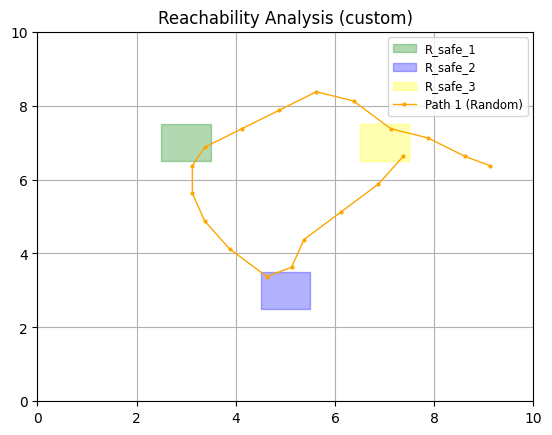

Path length: 19
Final state: q_accept
🎮 Starting Controller Simulation from (36, 25, 24)...
✅ GOAL REACHED! Steps: 35


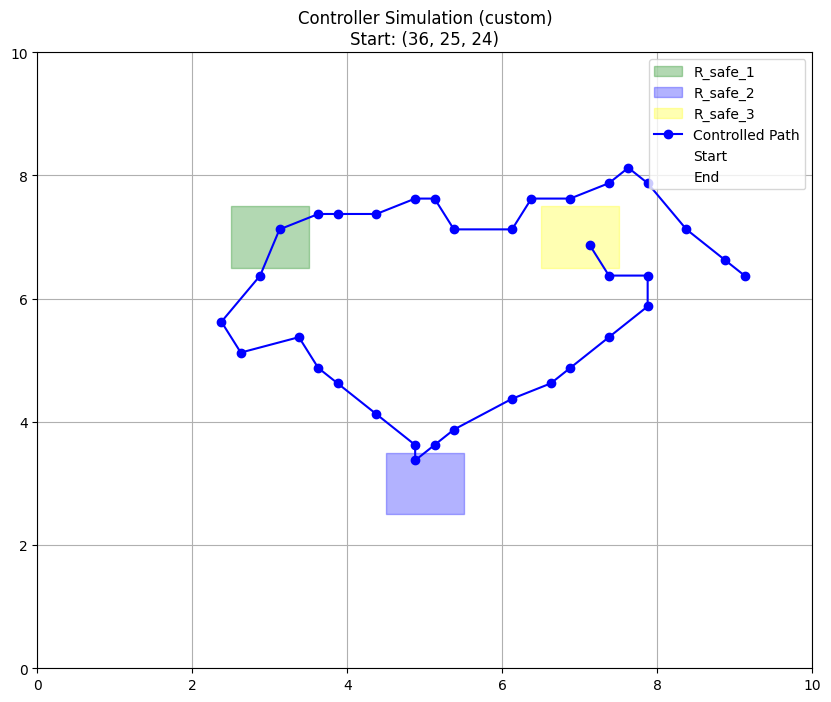

🎯 Running 50 simulations from FIXED start: (np.float64(9.125), np.float64(6.375), np.float64(1.9896753472735353))


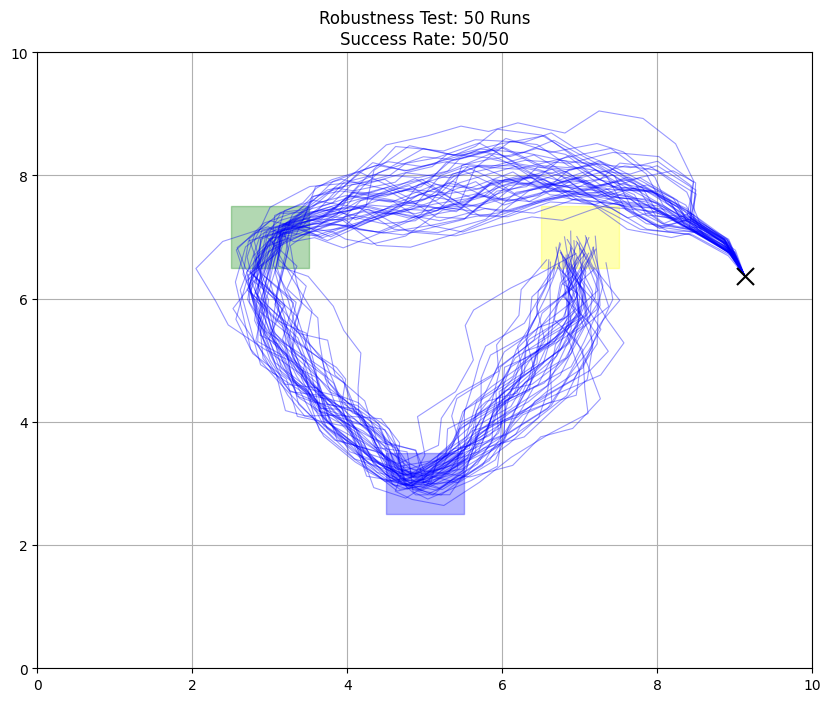


Simulate again with the same automaton and regions but with different starting positions? (Press Enter to accept suggested starts) [y/N]: y
Enter start position 1 as 'x y theta' (press Enter to use suggested (np.float64(3.125), np.float64(5.375), np.float64(-1.5707963267948966))): 
Enter start position 2 as 'x y theta' (press Enter to use suggested (np.float64(6.375), np.float64(6.125), np.float64(1.1519173063162573))): 
Controller guarantees satisfaction from (np.float64(3.125), np.float64(5.375), np.float64(-1.5707963267948966))
Start state in winning set? True
Searching for shortest path to {'q_accept'} using BFS...
Found a path!
Controller guarantees satisfaction from (np.float64(6.375), np.float64(6.125), np.float64(1.1519173063162569))
Start state in winning set? True
Searching for shortest path to {'q_accept'} using BFS...
Found a path!
Controller Size: 127428


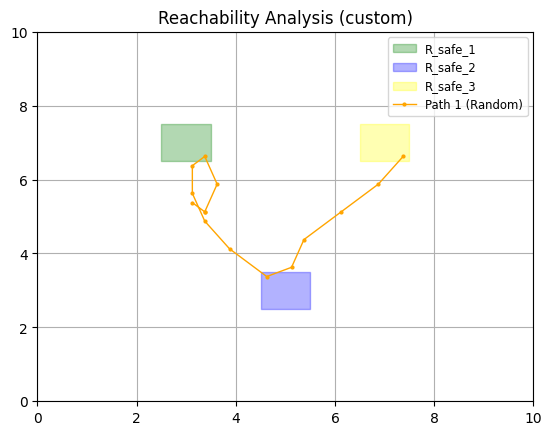

Path length: 15
Final state: q_accept
🎮 Starting Controller Simulation from (12, 21, 7)...
✅ GOAL REACHED! Steps: 28


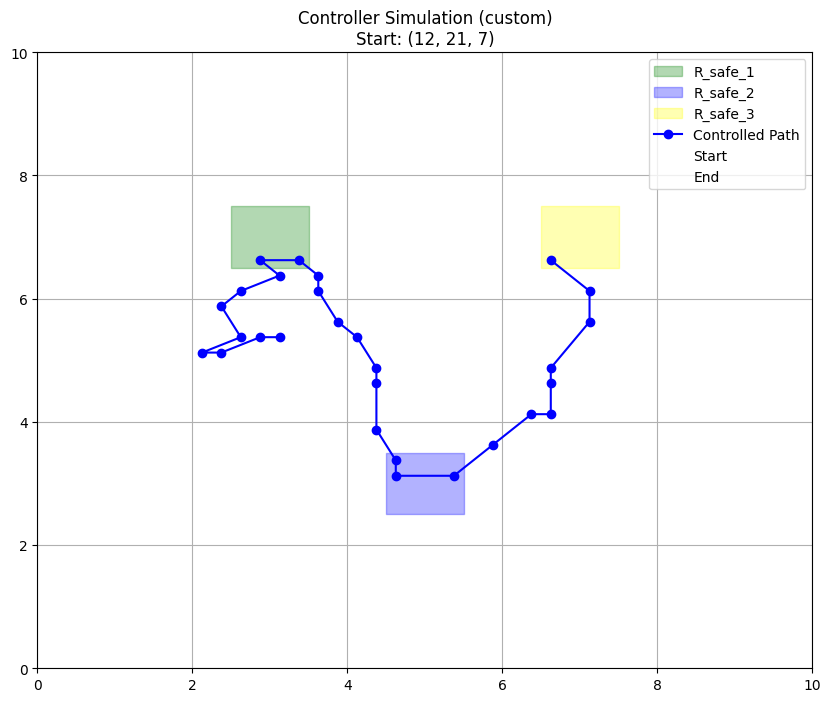

🎯 Running 50 simulations from FIXED start: (np.float64(3.125), np.float64(5.375), np.float64(-1.5707963267948966))


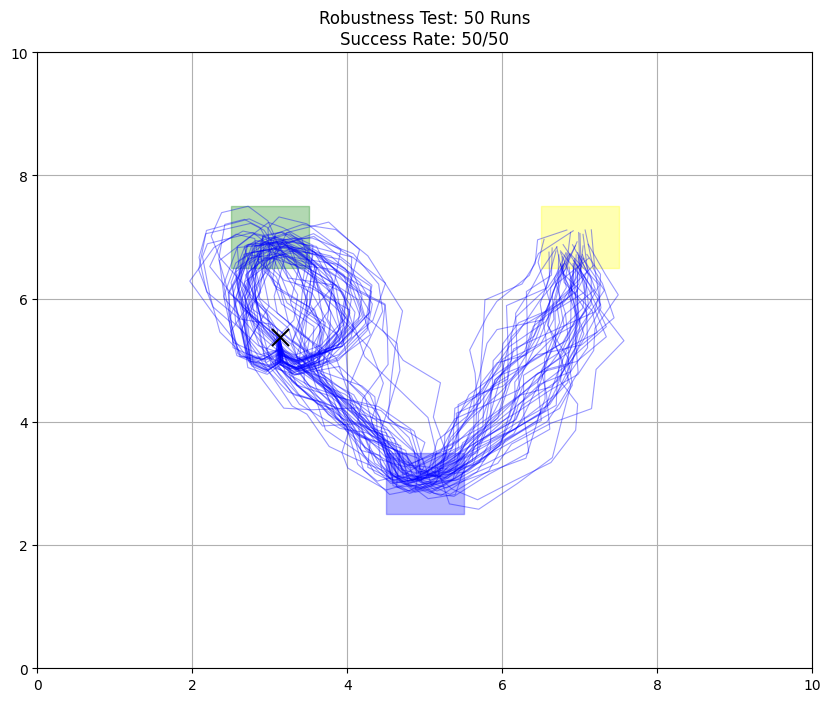


Simulate again with the same automaton and regions but with different starting positions? (Press Enter to accept suggested starts) [y/N]: N

All tasks complete. You can re-run this cell to try different scenario.
Or you can rerun the cell below to resimulate using this exact same automaton and regions, the starting point can be generated randomly but refer to the ploting functions if you want to change it
You can also resimulate here now without needing the cell below by answering the prompt above.


In [29]:
# === Terminal-style orchestrator ===

def prompt_choice(prompt, options):
    while True:
        print(prompt)
        for idx, label in options.items():
            print(f"  {idx}. {label}")
        selection = input("Select an option: ").strip()
        if selection.isdigit() and int(selection) in options:
            return int(selection)
        print("Invalid choice. Try again.\n")


def prompt_yes_no(prompt, default="y"):
    default = default.lower()
    while True:
        ans = input(f"{prompt} [{'Y/n' if default=='y' else 'y/N'}]: ").strip().lower()
        if not ans:
            return default == 'y'
        if ans in ("y", "yes"):
            return True
        if ans in ("n", "no"):
            return False
        print("Please respond with y or n.")


def prompt_rectangle(label):
    while True:
        raw = input(f"{label} (format: x_min x_max y_min y_max): ").strip()
        try:
            vals = list(map(float, raw.split()))
        except ValueError:
            print("Please enter four numeric values.")
            continue
        if len(vals) != 4:
            print("Need exactly four numbers.")
            continue
        rect = [[vals[0], vals[1]], [vals[2], vals[3]]]
        if not validate_region(rect):
            print("Invalid rectangle. Ensure x_min<x_max, y_min<y_max, inside workspace.")
            continue
        return rect


def manage_danger_zones(current_zones):
    zones = dict(current_zones)
    while True:
        print("\nDanger Zone Editor:")
        print("  1. Add zone")
        print("  2. Remove zone")
        print("  3. Finish editing")
        choice = input("Select: ").strip()
        if choice == '1':
            name = input("Enter zone name (e.g., R_unsafe_1): ").strip()
            if not name:
                print("Name required.")
                continue
            rect = prompt_rectangle(f"Bounds for {name}")
            zones[name] = rect
            print(f"Added {name}: {rect}")
        elif choice == '2':
            if not zones:
                print("No zones to remove.")
                continue
            print("Existing zones:", ", ".join(zones.keys()))
            target = input("Name to remove: ").strip()
            if target in zones:
                zones.pop(target)
                print(f"Removed {target}.")
            else:
                print("Zone not found.")
        elif choice == '3':
            break
        else:
            print("Invalid selection.")
    return zones


def prompt_start_positions(num_positions=2):
    """Prompt the user for start positions, offering controller-based suggestions."""
    suggestions = suggest_start_positions(num_positions)
    positions = []
    for idx in range(num_positions):
        suggested = suggestions[idx] if idx < len(suggestions) else None
        while True:
            hint = f" (press Enter to use suggested {suggested})" if suggested else ""
            raw = input(f"Enter start position {idx+1} as 'x y theta'{hint}: ").strip()
            if not raw and suggested is not None:
                positions.append(_sanitize_position(suggested))
                break
            parts = raw.split()
            if len(parts) != 3:
                print("Please enter exactly three numbers for x y theta.")
                continue
            try:
                vals = tuple(map(float, parts))
            except ValueError:
                print("Could not parse numbers; try again.")
                continue
            positions.append(_sanitize_position(vals))
            break
    return positions


def apply_region_updates(custom_alphabet=None):
    global regions_number, danger_zones_number, All_regions, region_for_labels, CORE_LABELS, labelTable
    regions_number = len(regions)
    danger_zones_number = len(danger_zones)
    All_regions = {**regions, **danger_zones}
    region_for_labels = [
        (rect[0][0], rect[1][0], rect[0][1], rect[1][1])
        for rect in list(regions.values()) + list(danger_zones.values())
    ]
    if custom_alphabet:
        CORE_LABELS = custom_alphabet
    else:
        CORE_LABELS = ["none"] + list(regions.keys()) + list(danger_zones.keys())
    labelTable.clear()
    print("\nRecalculating Label Table with Center/Collision logic...")
    for i in tqdm.tqdm(range(Nx1)):
        for j in range(Nx2):
            for k in range(Nx3):
                labelTable.append(labels((i, j, k)))
    print(f"✓ Label table ready ({len(labelTable)} entries).")


def configure_automaton(spec, visit_params=None, automaton_json_data=None):
    global automaton_states, automaton_initial, automaton_accepting, automaton_transition, automaton_transition_table
    if spec == "original":
        automaton_states    = automaton_states_original
        automaton_initial   = automaton_initial_original
        automaton_accepting = automaton_accepting_original
        automaton_transition = automaton_transition_original
        automaton_transition_table = build_automaton_table_from_function(
            automaton_states, automaton_transition, alphabet=CORE_LABELS
        )
    elif spec == "strict":
        automaton_states    = automaton_states_strict
        automaton_initial   = automaton_initial_strict
        automaton_accepting = automaton_accepting_strict
        automaton_transition = automaton_transition_strict
        automaton_transition_table = build_automaton_table_from_function(
            automaton_states, automaton_transition, alphabet=CORE_LABELS
        )
    elif spec == "fairness":
        automaton_states    = automaton_states_fairness
        automaton_initial   = automaton_initial_fairness
        automaton_accepting = automaton_accepting_fairness
        automaton_transition = automaton_transition_fairness
        automaton_transition_table = build_automaton_table_from_function(
            automaton_states, automaton_transition, alphabet=CORE_LABELS
        )
    elif spec == "visit_counts":
        n, m = visit_params or (2, 2)
        automaton_states_local, automaton_initial_local, automaton_accepting_local = build_automaton_visit_counts(n, m)
        automaton_states    = automaton_states_local
        automaton_initial   = automaton_initial_local
        automaton_accepting = automaton_accepting_local
        automaton_transition = lambda q, lab: automaton_transition_visit_counts(q, lab, n, m)
        automaton_transition_table = build_automaton_table_from_function(
            automaton_states, automaton_transition, alphabet=CORE_LABELS
        )
    elif spec == "custom":
        if automaton_json_data is None:
            raise RuntimeError("Custom specification requires automaton JSON data.")
        (
            automaton_states,
            automaton_initial,
            automaton_accepting,
            automaton_transition,
            automaton_transition_table,
        ) = build_automaton_custom_from_json(automaton_json_data)
    else:
        raise ValueError(f"Unknown specification {spec}")

    unreachable = find_unreachable_automaton_states(automaton_states, automaton_initial, automaton_transition_table, alphabet=CORE_LABELS)
    if unreachable:
        print("⚠ Unreachable automaton states:", unreachable)
    else:
        print("✓ All automaton states are reachable.")


def prepare_transition_table(regenerate):
    global transition_table
    cache_path = "transition_table.pkl"
    if not regenerate and os.path.exists(cache_path):
        with open(cache_path, "rb") as fh:
            transition_table = pickle.load(fh)
        print(f"Loaded transition table from {cache_path}.")
        return

    print("Building transition table (this may take a while)...")
    for s in tqdm.tqdm(all_states):
        for u_idx in all_inputs:
            succ = delta(index_to_state(s), u[u_idx])
            transition_table[SCtoindex(s, u_idx)] = [state_to_index(successor) for successor in succ]
    with open(cache_path, "wb") as fh:
        pickle.dump(transition_table, fh)
    print(f"Saved transition table to {cache_path}.")


def build_safety_and_reachability():
    global forbidden_states, Qs_raw, Qs_safe, safe_controllers, all_product_states, all_accepted_states, Qaf, winning_initial_states
    forbidden_states = set()
    for ((x1l, x1h), (x2l, x2h)) in danger_zones.values():
        for i in range(Nx1):
            for j in range(Nx2):
                cx, cy = cell_center(i, j)
                if x1l <= cx <= x1h and x2l <= cy <= x2h:
                    for k in range(Nx3):
                        forbidden_states.add(state_to_index((i, j, k)))
    Qs_raw = all_states - forbidden_states
    print(f"Running safety fixpoint over {len(Qs_raw)} candidate states...")
    Qs_safe, safe_controllers = safety(Qs_raw)
    print(f"Safe region size: {len(Qs_safe)} states")

    all_product_states = {
        product_state_to_index(index_to_state(state), label)
        for state in Qs_safe
        for label in automaton_states
    }
    all_accepted_states = {
        product_state_to_index(index_to_state(state), accept_state)
        for state in Qs_safe
        for accept_state in automaton_accepting
    }

    pickle_name = f"Reacheable_Elements_{SPECIFICATION}.pkl"
    load_existing = False
    if os.path.exists(pickle_name):
        load_existing = prompt_yes_no(f"Load existing reachability data from {pickle_name}?", default="y")

    if load_existing and os.path.exists(pickle_name):
        with open(pickle_name, "rb") as fh:
            Qaf = pickle.load(fh)
        print(f"Loaded reachability controller from {pickle_name}.")
    else:
        Qaf = reachability_controller_product(all_accepted_states)
        with open(pickle_name, "wb") as fh:
            pickle.dump(Qaf, fh)
        print(f"Reachability controller saved to {pickle_name}.")

    winning_initial_states = set()
    num_auto = len(automaton_states)
    for prod_state_int in Qaf[0]:
        auto_idx = prod_state_int % num_auto
        if automaton_states[auto_idx] == automaton_initial:
            phys_idx = prod_state_int // num_auto
            winning_initial_states.add(index_to_state(phys_idx))
    print(f"Winning initial symbolic states: {len(winning_initial_states)}")


print("="*72)
print("Symbolic Control CLI")
print("="*72)

spec_map = {
    1: "original",
    2: "strict",
    3: "fairness",
    4: "visit_counts",
    5: "custom",
}

spec_choice = prompt_choice("Select specification automaton:", spec_map)
SPECIFICATION = spec_map[spec_choice]
visit_params = None
custom_data = None

if SPECIFICATION == "visit_counts":
    n = int(input("Enter visits required for R_safe_1 (n): "))
    m = int(input("Enter visits required for R_safe_2 (m): "))
    visit_params = (n, m)

if SPECIFICATION != "custom":

    print(
        """Using default safe regions:
        R1 = [[4.0, 5.0], [8.5, 9.5]]
        R2 = [[8.5, 9.5], [2.0, 3.0]]
        R3 = [[2.0, 3.0], [0.5, 1.5]]
    """
    )
    regions = {
        "R_safe_1": [[4.0, 5.0], [8.5, 9.5]],
        "R_safe_2": [[8.5, 9.5], [2.0, 3.0]],
        "R_safe_3": [[2.0, 3.0], [0.5, 1.5]],
    }
    danger_zones = {}
    if prompt_yes_no("Modify danger zones now?"):
        danger_zones = manage_danger_zones(danger_zones)
else:
    print("\nCustom mode selected.")
    manual_regions = prompt_yes_no("Provide your own regions before invoking the AI?")
    if manual_regions:
        regions = {}
        n_safe = int(input("Number of safe regions: "))
        for i in range(n_safe):
            regions[f"R_safe_{i+1}"] = prompt_rectangle(f"Safe region {i+1}")
        danger_zones = {}
        n_dz = int(input("Number of unsafe regions: "))
        for i in range(n_dz):
            danger_zones[f"R_unsafe_{i+1}"] = prompt_rectangle(f"Danger zone {i+1}")
    else:
        regions = {}
        danger_zones = {}
    print("Enter natural-language specification (e.g., 'Go to R_safe_1 then R_safe_2 while avoiding R_unsafe_1'):")
    user_spec = input("> ")
    prompt = build_unified_prompt(
        user_spec=user_spec,
        regions_source=("user" if manual_regions else "ai"),
        regions=regions,
        danger_zones=danger_zones,
    )
    import google.api_core.exceptions as gex

    def try_generate(model_name, prompt):
        """Try generating with a given model. Return response or raise."""
        m = genai.GenerativeModel(model_name)
        return m.generate_content(
            prompt,
            generation_config=genai.types.GenerationConfig(
                response_mime_type="application/json",
                temperature=0.15,
            )
        )

    model_order = ["gemini-2.5-pro", "gemini-2.5", "gemini-2.5-flash"]
    ai_resp = None
    used_model = None

    for candidate in model_order:
        print(f"Trying {candidate}...")
        try:
            ai_resp = try_generate(candidate, prompt)
            used_model = candidate
            print(f"✓ Succeeded with {candidate}")
            break
        except gex.ResourceExhausted:
            print(f"⚠ Quota exhausted for {candidate}, trying next.")
            continue
        except gex.TooManyRequests:
            print(f"⚠ 429 for {candidate}, trying next.")
            continue
        except Exception as e:
            print(f"⚠ Failed with {candidate}: {e}")
            continue

    if ai_resp is None:
        raise RuntimeError("All models failed. No quota left anywhere.")

    # You can now parse ai_resp safely.
    data = json.loads(ai_resp.text)
    regions = data.get("regions", {})
    danger_zones = data.get("danger_zones", {})
    custom_alphabet = data.get("alphabet", [])
    custom_data = data.get("automaton", {})

    print(f"\nUsed model: {used_model}")

    print("\n=== AI Regions ===")
    print(json.dumps(regions, indent=2))
    print("\n=== AI Danger Zones ===")
    print(json.dumps(danger_zones, indent=2))
    print("\n=== Alphabet ===")
    print(custom_alphabet)
    print("\n=== AUTOMATON (structure) ===")
    print(json.dumps(custom_data, indent=2))
    if not custom_alphabet:
        custom_alphabet = ["none"] + list(regions.keys()) + list(danger_zones.keys())
    apply_region_updates(custom_alphabet=custom_alphabet)
    configure_automaton(SPECIFICATION, visit_params=visit_params, automaton_json_data=custom_data)

if SPECIFICATION != "custom":
    apply_region_updates()
    configure_automaton(SPECIFICATION, visit_params=visit_params)

regen_choice = prompt_choice("\nTransition table options:", {1: "Load from cache (if available)", 2: "Regenerate now"})
prepare_transition_table(regenerate=(regen_choice == 2))

build_safety_and_reachability()

print("\nSummary:")
print(f"  Spec: {SPECIFICATION}")
print(f"  Safe cells: {len(Qs_safe)}")
print(f"  Product states: {len(all_product_states)}")
print(f"  Accepted product states: {len(all_accepted_states)}")
print(f"  Winning initials: {len(winning_initial_states)}")
print(f"  Controller entries: {len(Qaf[1])}")

if prompt_yes_no("Export automaton to DOT?", default="n"):
    filename = f"{SPECIFICATION}_automaton.dot"
    export_automaton_to_dot(
        filename,
        automaton_states,
        automaton_initial,
        automaton_accepting,
        automaton_transition_table,
        alphabet=CORE_LABELS,
    )
    if prompt_yes_no("Generate PNG via Graphviz now?", default="n"):
        os.system(f"dot -Tpng {filename} -o {filename.replace('.dot', '.png')}")

if prompt_yes_no("Show automaton transition table?", default="n"):
    print_transition_table(automaton_states, automaton_transition_table, alphabet=CORE_LABELS)

print("\nRendering visualizations automatically (Colab-friendly mode)...")
initial_start_positions = suggest_start_positions(2)
plot_regions(start_positions=initial_start_positions)
plot_controller_simulation(start_tuple=initial_start_positions[0] if initial_start_positions else None)
default_runs = 50  # reasonable number for quick robustness sweep
plot_multiple_runs(default_runs, fixed_start_x=initial_start_positions[0] if initial_start_positions else None)

while prompt_yes_no("\nSimulate again with the same automaton and regions but with different starting positions? (Press Enter to accept suggested starts)", default="n"):
    user_positions = prompt_start_positions()
    plot_regions(start_positions=user_positions)
    plot_controller_simulation(start_tuple=user_positions[0])
    plot_multiple_runs(default_runs, fixed_start_x=user_positions[0])

print("\nAll tasks complete. You can re-run this cell to try different scenario.")
print("Or you can rerun the cell below to resimulate using this exact same automaton and regions, the starting point can be generated randomly but refer to the ploting functions if you want to change it")
print("You can also resimulate here now without needing the cell below by answering the prompt above.")

# Replot

Picked RANDOM valid start state from controller: (np.float64(9.375), np.float64(7.375), np.float64(-2.827433388230814))
Controller guarantees satisfaction from (np.float64(9.375), np.float64(7.375), np.float64(-2.827433388230814))
Start state in winning set? True
Searching for shortest path to {'q_accept'} using BFS...
Found a path!
Controller guarantees satisfaction from (np.float64(2.625), np.float64(4.625), np.float64(-0.5235987755982991))
Start state in winning set? True
Searching for shortest path to {'q_accept'} using BFS...
Found a path!
Controller Size: 127428


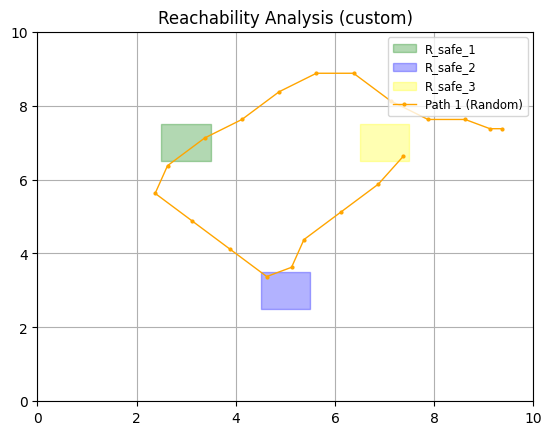

Path length: 20
Final state: q_accept
🎮 Starting Controller Simulation from (29, 5, 3)...
✅ GOAL REACHED! Steps: 42


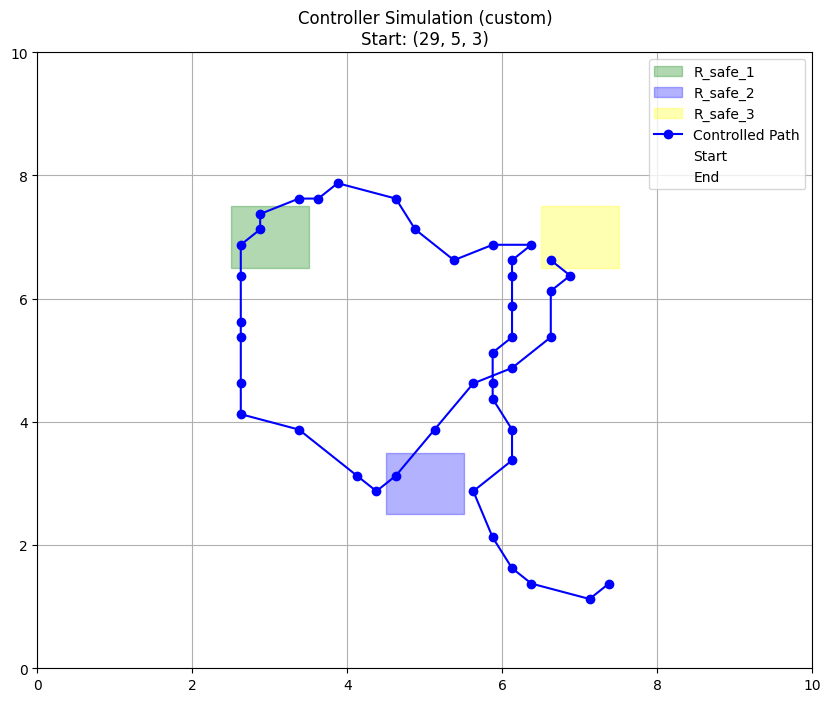

🎯 Running 50 simulations from FIXED start: (np.float64(1.125), np.float64(4.375), np.float64(1.3613568165555767))


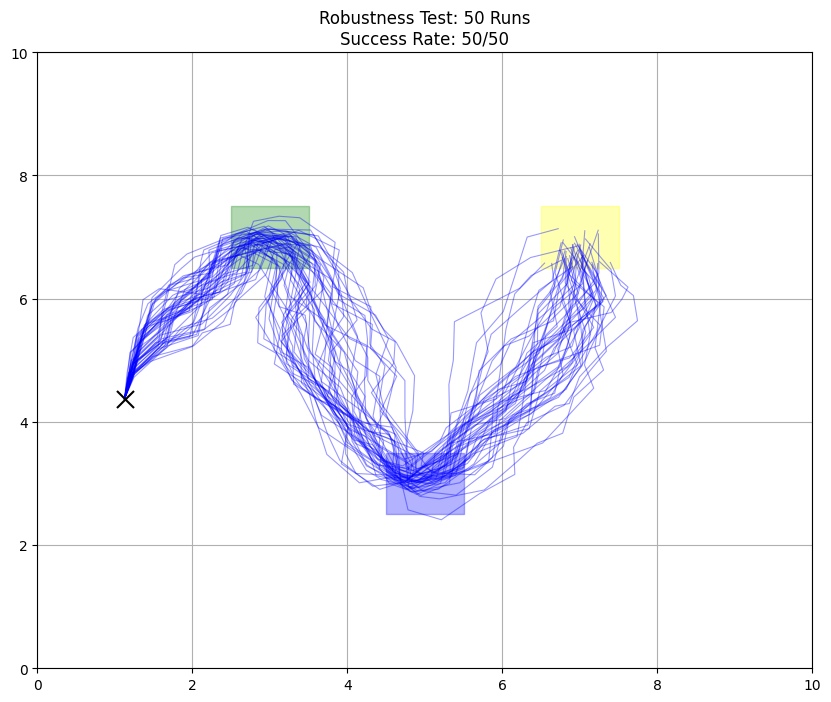

In [30]:
plot_regions()
plot_controller_simulation()
plot_multiple_runs()